In [1]:
path = 'dens_runtime.txt'
path = 'dens_runtime_v2.txt'


In [2]:
import pandas as pd
import re
import numpy as np

# Read file
with open(path, "r") as f:
    lines = f.readlines()

data = []
w = k = None
order_type = None

for line in lines:
    line = line.strip()

    # Detect random order
    rand_match = re.match(r"Using random order for w=(\d+)\s+and\s+k=(\d+)", line)
    if rand_match:
        w, k = map(int, rand_match.groups())
        order_type = "random"
        continue

    # Detect ordered order
    ordered_match = re.match(r"Loading order from path orders/w(\d+)_k(\d+)\.gm", line)
    if ordered_match:
        w, k = map(int, ordered_match.groups())
        order_type = "ordered"
        continue

    # Skip missing order message
    if "No order for" in line:
        continue

    # Detect benchmark line with "Total result"
    bench_match = re.match(
        r"Benchmark ([\w_]+):\s+mean =\s*([\d.]+) ms, std =\s*([\d.]+) ms\s+Total result: (\d+)",
        line
    )
    if bench_match:
        algo, mean, std, total = bench_match.groups()
        data.append({
            "w": w,
            "k": k,
            "order_type": order_type,
            "algorithm": algo,
            "mean": float(mean),
            "std": float(std),
            "total_result": int(total)
        })

# Create DataFrame
df = pd.DataFrame(data)

df.to_csv('dens_runtime.csv', index=False)

df['mean'] = df['mean'].apply(lambda x: 0.001 if x == 0 else x)

# Apply log10 to 'mean'
df['mean'] = df['mean'].apply(lambda x: round(np.log10(x), 3))

# Preview
print(df.head())
print(len(df))



   w  k order_type algorithm   mean  std  total_result
0  3  3     random  denDP_v2 -2.699  0.0          3000
1  3  3     random   fast_gc -3.000  0.0          3000
2  3  3     random   denLFSR -3.000  0.0        201600
3  3  3    ordered  denDP_v2 -2.699  0.0          2900
4  3  3    ordered   fast_gc -3.000  0.0          2900
846


random w=k

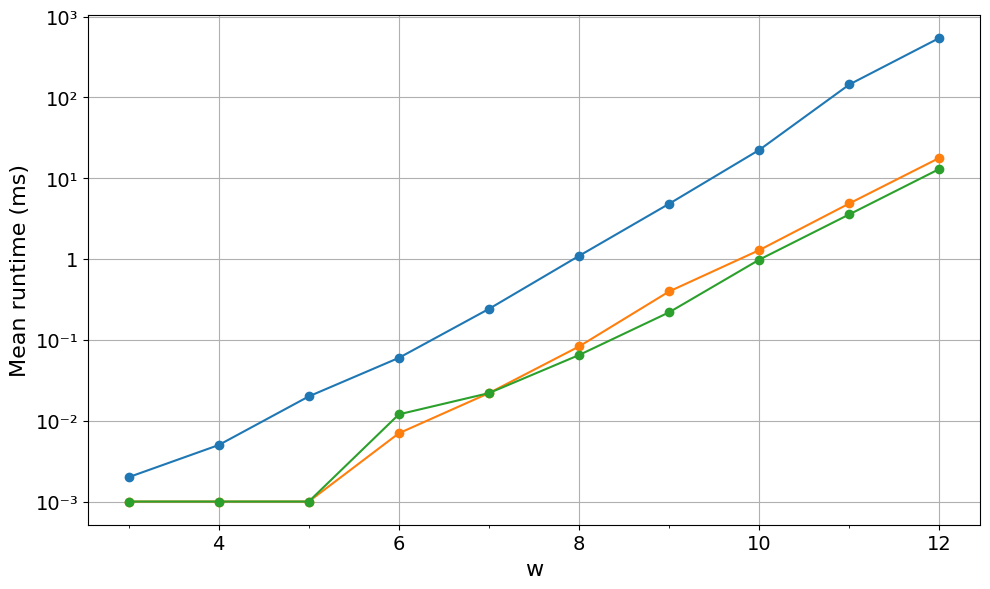

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def format_as_power_of_10(x, _):
    if x == 0:
        return "1"
    exp = int(round(x))
    superscript = str(exp).translate(str.maketrans("0123456789-", "⁰¹²³⁴⁵⁶⁷⁸⁹⁻"))
    return f"10{superscript}"

# Filter only random order and w == k
df_filtered = df[(df['order_type'] == 'random') & (df['w'] == df['k'])]

# Sort by w for proper line plotting
df_filtered = df_filtered.sort_values(by="w")

# Pivot to get log10(mean) values per algorithm
pivot_df = df_filtered.pivot(index="w", columns="algorithm", values="mean")

# Plot
plt.figure(figsize=(10, 6))
for algo in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[algo], marker='o')

plt.xlabel("w", fontsize=16)
plt.ylabel("Mean runtime (ms)", fontsize=16)

from matplotlib.ticker import MultipleLocator, NullFormatter

ax = plt.gca()

# Major ticks: even numbers with labels
ax.set_xticks(np.arange(4, 13, 2))
ax.set_xticklabels(np.arange(4, 13, 2), fontsize=14)

# Minor ticks: odd numbers without labels
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_minor_formatter(NullFormatter())
plt.yticks(fontsize=14)

# Replace y-tick labels with 10^x format
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_as_power_of_10))

plt.grid(True)
plt.tight_layout()
plt.savefig("dens_runtime_random_w_eq_k.svg")
plt.show()


GM w=k

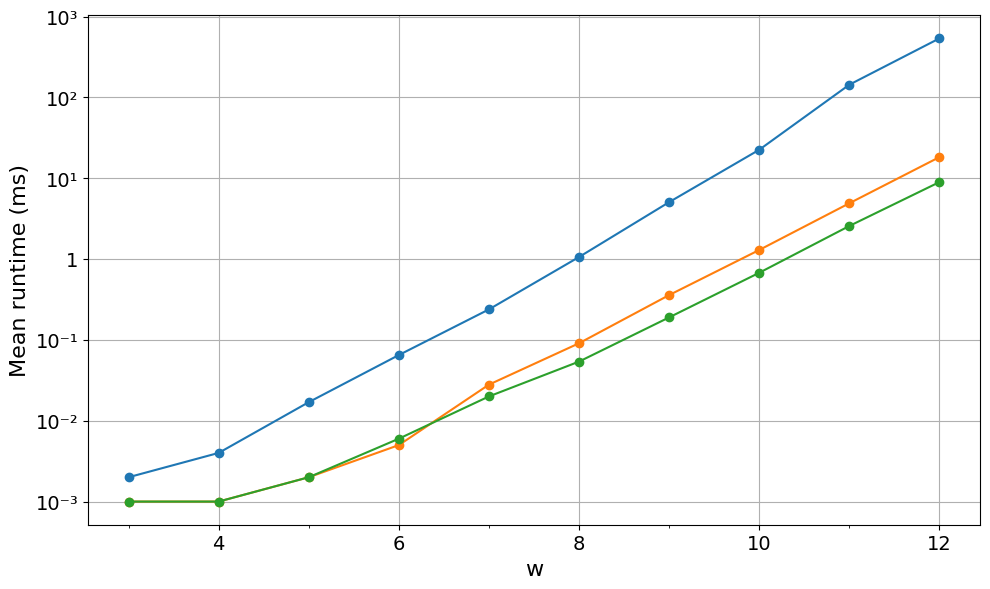

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def format_as_power_of_10(x, _):
    if x == 0:
        return "1"
    exp = int(round(x))
    superscript = str(exp).translate(str.maketrans("0123456789-", "⁰¹²³⁴⁵⁶⁷⁸⁹⁻"))
    return f"10{superscript}"

# Filter only ordered data where w == k
df_filtered_ordered = df[(df['order_type'] == 'ordered') & (df['w'] == df['k'])]

# Sort by w for clean line plotting
df_filtered_ordered = df_filtered_ordered.sort_values(by="w")

# Pivot to reshape: rows are w, columns are algorithm, values are mean
pivot_ordered = df_filtered_ordered.pivot(index="w", columns="algorithm", values="mean")

# Plot
plt.figure(figsize=(10, 6))
for algo in pivot_ordered.columns:
    plt.plot(pivot_ordered.index, pivot_ordered[algo], marker='o', label=algo)

plt.xlabel("w", fontsize=16)
plt.ylabel("Mean runtime (ms)", fontsize=16)

from matplotlib.ticker import MultipleLocator, NullFormatter

ax = plt.gca()

# Major ticks: even numbers with labels
ax.set_xticks(np.arange(4, 13, 2))
ax.set_xticklabels(np.arange(4, 13, 2), fontsize=14)

# Minor ticks: odd numbers without labels
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_minor_formatter(NullFormatter())
plt.yticks(fontsize=14)

# Format y-ticks as 10^x style
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_as_power_of_10))

plt.grid(True)
plt.tight_layout()
plt.savefig("dens_runtime_gm_w_eq_k.svg")
plt.show()


gm fixed k

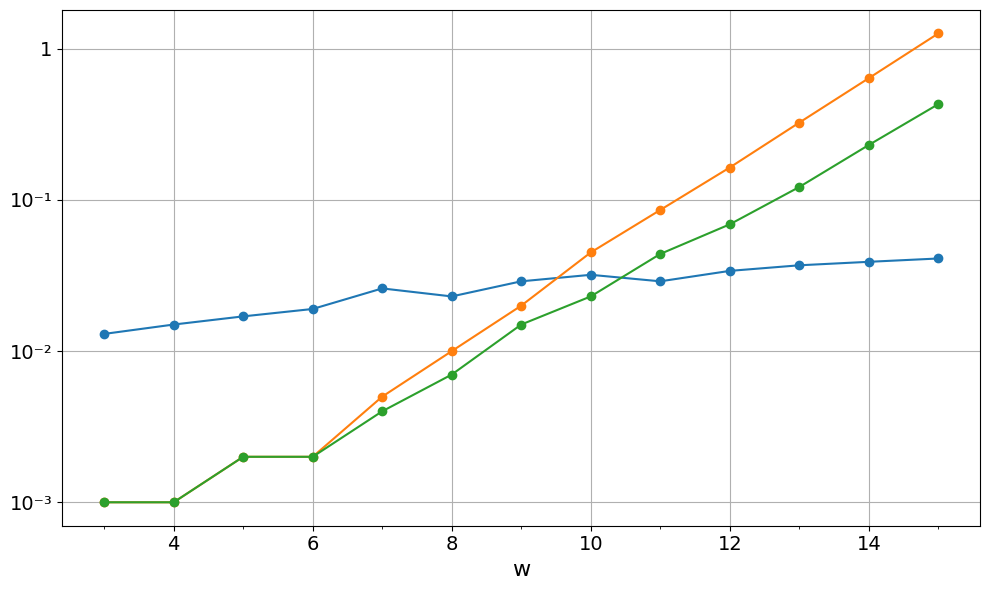

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Set y-axis to log scale

def format_as_power_of_10(x, _):
    if x == 0:
        return "1"
    exp = int(round(x))
    superscript = str(exp).translate(str.maketrans("0123456789-", "⁰¹²³⁴⁵⁶⁷⁸⁹⁻"))
    return f"10{superscript}"

# Filter: ordered data with fixed k=5
df_k5_ordered = df[(df['order_type'] == 'ordered') & (df['k'] == 5)]

# Sort by w for plotting
df_k5_ordered = df_k5_ordered.sort_values(by="w")

# Pivot to reshape for plotting
pivot_k5 = df_k5_ordered.pivot(index="w", columns="algorithm", values="mean")

# Plot
plt.figure(figsize=(10, 6))
for algo in pivot_k5.columns:
    plt.plot(pivot_k5.index, pivot_k5[algo], marker='o', label=algo)

plt.xlabel("w", fontsize=16)
#plt.ylabel("Mean runtime (ms)", fontsize=14)

y_ticks_labels = [-3,-2,-1,0]

from matplotlib.ticker import MultipleLocator, NullFormatter

ax = plt.gca()

# Major ticks: even numbers with labels
ax.set_xticks(np.arange(4, 15, 2))
ax.set_xticklabels(np.arange(4, 15, 2), fontsize=14)

# Minor ticks: odd numbers without labels
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_minor_formatter(NullFormatter())
plt.yticks(y_ticks_labels, fontsize=14)

# Format y-ticks as powers of 10
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_as_power_of_10))

plt.grid(True)
plt.tight_layout()
plt.savefig("dens_runtime_gm_w_k5.svg")
plt.show()


random fixed k

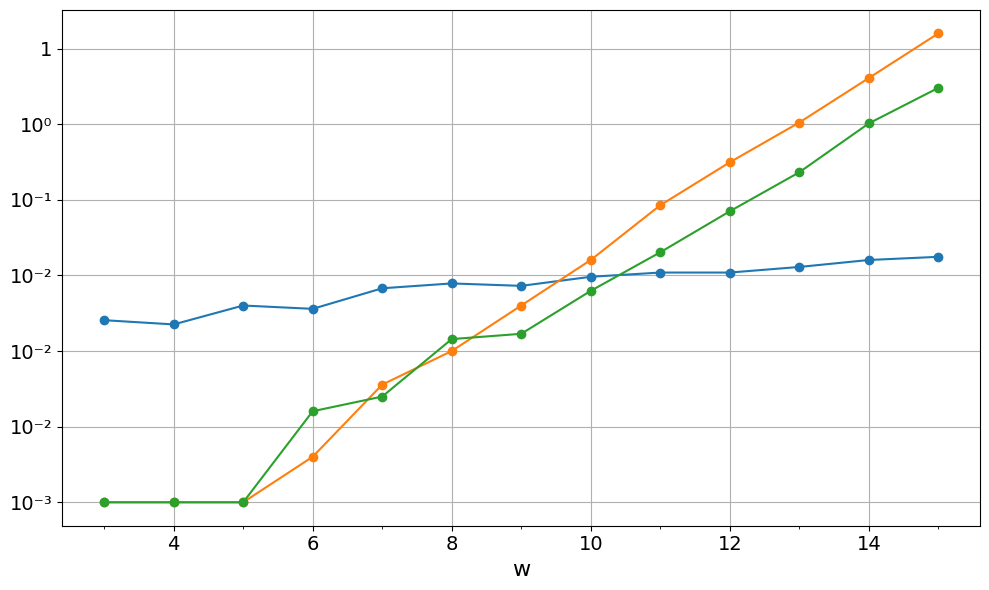

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def format_as_power_of_10(x, _):
    if x == 0:
        return "1"
    exp = int(round(x))
    superscript = str(exp).translate(str.maketrans("0123456789-", "⁰¹²³⁴⁵⁶⁷⁸⁹⁻"))
    return f"10{superscript}"

# Filter: random (unordered) data with fixed k=5
df_k5_random = df[(df['order_type'] == 'random') & (df['k'] == 5)]

# discard all w values above 15
df_k5_random = df_k5_random[df_k5_random['w'] <= 15]

# Sort by w for plotting
df_k5_random = df_k5_random.sort_values(by="w")

# Pivot: rows = w, columns = algorithm, values = mean
pivot_k5_random = df_k5_random.pivot(index="w", columns="algorithm", values="mean")

# Plot
plt.figure(figsize=(10, 6))
for algo in pivot_k5_random.columns:
    plt.plot(pivot_k5_random.index, pivot_k5_random[algo], marker='o', label=algo)

plt.xlabel("w", fontsize=16)
#plt.ylabel("Mean runtime (ms)", fontsize=14)

# x ticks should be every 2 numbers, starting from 4 with ticks on odd numbers
from matplotlib.ticker import MultipleLocator, NullFormatter

ax = plt.gca()

# Major ticks: even numbers with labels
ax.set_xticks(np.arange(4, 15, 2))
ax.set_xticklabels(np.arange(4, 15, 2), fontsize=14)

# Minor ticks: odd numbers without labels
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_minor_formatter(NullFormatter())
plt.yticks(fontsize=14)



plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Format y-tick labels as 10^x
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_as_power_of_10))

plt.grid(True)
plt.tight_layout()
plt.savefig("dens_runtime_random_w_k5.svg")
plt.show()
